## Explaining ResNET-50 predictions with LIME


In [1]:
!pip install lime
!pip install shap

In [2]:
import json
import os
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision.models import resnet50
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision

# reading lime_image
from lime import lime_image
import shap

from skimage.segmentation import mark_boundaries 

In [3]:
# Set random seed for reproducibility.
np.random.seed(0)
torch.manual_seed(0) 

device ="cuda:0" if torch.cuda.is_available() else "cpu"

## Interpreting ResNet model

We focus on interpreting ResNet model. Below, we load the model. We also need the class descriptions for the ImageNet dataset which the ResNet is trained on. This information is available in a json file which again we read below.

In [4]:
# loading the model
resnet = resnet50(pretrained=True)

for module in resnet.modules():
    if isinstance(module, torch.nn.ReLU):
        module.inplace = False
resnet = resnet.eval().to(device)

# loading the dataset
X, _ = shap.datasets.imagenet50()

# reading imagenet classes
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
# print("Number of ImageNet classes:", len(class_names))
# print("Class names:", class_names)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s] 


### Utility functions to satisfy ResNet requirements

We need to develop a couple of utility function. Below, we implement a function to read an image and construct a torch tensor for the ResNet model. We recall that the ResNet model requires images to be normalized (RGB channels). 

We also need a function to convert an image to a torch tensor without normalizing. The latter is used with the LIME package.  

In [5]:
# resize and take the center part of image to what our model expects
def pil_to_torch(img):
    transf = T.Compose([
        T.Resize((256, 256)),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]) 
    ])        
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

def pil_transform(img): 
    transf = T.Compose([
        T.Resize((256, 256)),
        T.CenterCrop(224)
    ])    

    return transf(img)

### Utility function for LIME

We need to write a utility function to work with LIME. LIME will provide us with images where superpixels will turn-on and off and requires predictions in the form of class-probabilities to train its local model. hence, we need to write a function that gets images in the form of numpy arrays and make predictiosn using our ResNet model. 

In [6]:
def cnn_predict(images): 
    transf = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
        ])
    
    batch = torch.stack(tuple(transf(img) for img in images), dim=0)

    logits = resnet(batch.to(device)).cpu()
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

### Read an image

Here we use a sample image for explanation.

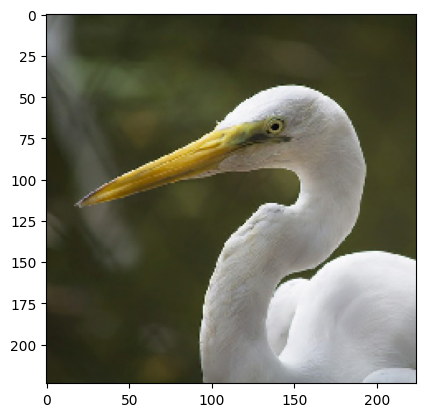

In [7]:
img_index = 1
img_array = X[img_index]

# Convert from float32 to uint8
if img_array.dtype == np.float32:
    img_array = (img_array).astype(np.uint8)


img_pil_0 = Image.fromarray(img_array)

_ = plt.imshow(img_pil_0)

### ResNet predicts as?

Let's see how the ResNet will recognize the image, is it a cat or a dog?

In [8]:
img_tensor = pil_to_torch(img_pil_0)

logits = resnet(img_tensor.to(device))
probs = F.softmax(logits, dim=1).cpu()
probs5 = probs.topk(5)
tuple((p,c, class_names[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.95209324, 132, 'American_egret'),
 (0.044492215, 134, 'crane'),
 (0.0026850004, 131, 'little_blue_heron'),
 (0.00021452805, 127, 'white_stork'),
 (0.00017003223, 144, 'pelican'))

### Use LIME to explain the ResNet

To use LIME, we need to first define an explainer object. Check the cell below for this purpose.
Then, we can use the method [explain_instance](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image) from the explainer object to understand the behaviour of Resnet. Run the "explain_instance" and discuss the results. 

In [9]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pil_transform(img_pil_0)), 
                                         cnn_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

After running LIME on our image, you can use various methods to visualize which parts of the image contributed to the decisions. Check the method [get_image_and_mask](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_image.ImageExplanation.get_image_and_mask) which can be used to visulize superpixels that **positively** or **negatively** contribute to the prediction of the label.

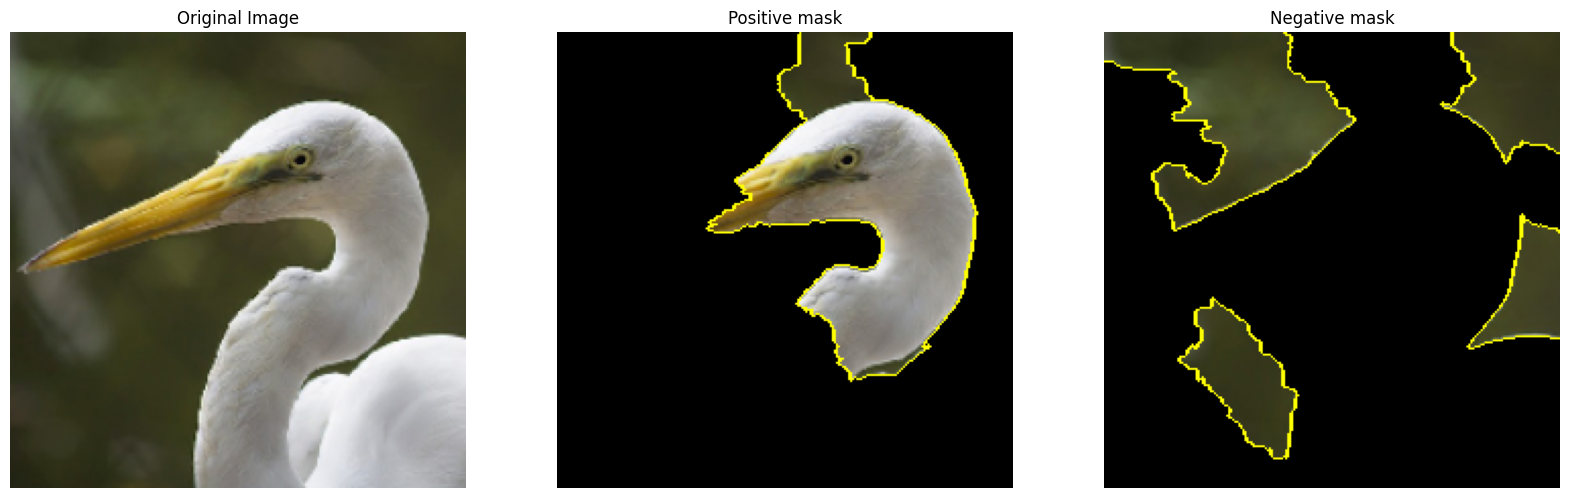

In [10]:
fig, axes = plt.subplots(1,3, figsize=(20, 10))

axes[0].imshow(pil_transform(img_pil_0))
axes[0].axis('off')
axes[0].set_title("Original Image")

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, negative_only=False, 
                                            num_features=5, hide_rest=True)

img_boundry = mark_boundaries(temp/255.0, mask)
axes[1].imshow(img_boundry)
axes[1].set_title("Positive mask")
axes[1].axis('off')

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, negative_only=True, 
                                            num_features=5, hide_rest=True)

img_boundry = mark_boundaries(temp/255.0, mask)
axes[2].imshow(img_boundry)
axes[2].set_title("Negative mask")
axes[2].axis('off')

plt.show()

## Lets try another image!

In [11]:
img_index = 2
img_array = X[img_index]

# Convert from float32 to uint8
if img_array.dtype == np.float32:
    img_array = (img_array).astype(np.uint8)


img_pil_1 = Image.fromarray(img_array)

img1 = pil_to_torch(img_pil_1)
logits = resnet(img1.to(device)).cpu()
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)

((0.99369746, 814, 'speedboat'),
 (0.0021373406, 408, 'amphibian'),
 (0.0016786468, 693, 'paddle'),
 (0.0003876762, 625, 'lifeboat'),
 (0.00036636565, 472, 'canoe'))

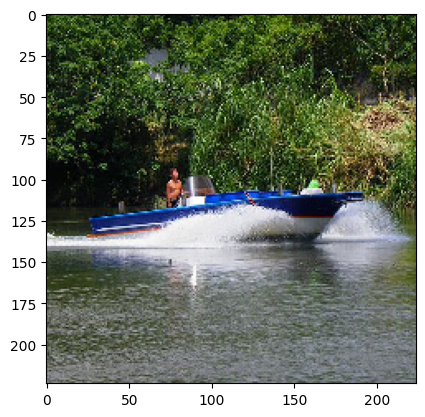

In [12]:
_ = plt.imshow(img_pil_1)
labels = tuple((p,c, class_names[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))
labels

In [13]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pil_transform(img_pil_1)), 
                                         cnn_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function


  0%|          | 0/1000 [00:00<?, ?it/s]

Looking at: lifeboat


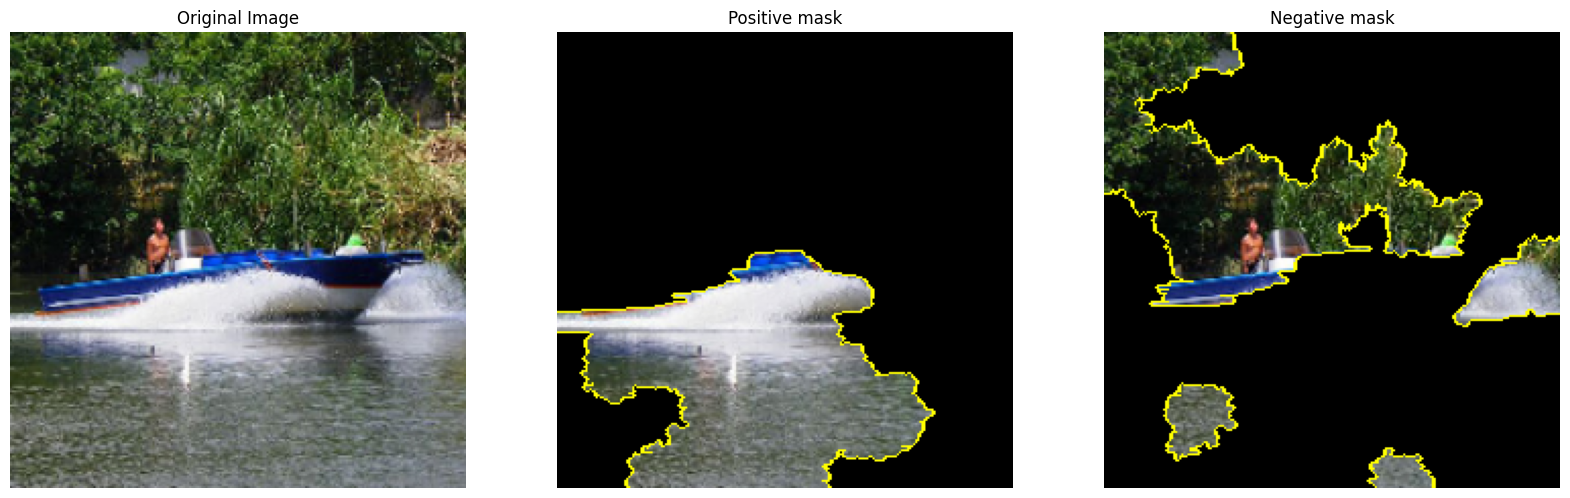

In [14]:
label = 3
print("Looking at:", labels[label][-1])

fig, axes = plt.subplots(1,3, figsize=(20, 10))
axes[0].imshow(pil_transform(img_pil_1))
axes[0].axis('off')
axes[0].set_title("Original Image")

temp, mask = explanation.get_image_and_mask(explanation.top_labels[label], positive_only=True, 
                                            negative_only=False, num_features=3, hide_rest=True)
img_boundry = mark_boundaries(temp/255.0, mask)
axes[1].imshow(img_boundry)
axes[1].set_title("Positive mask")
axes[1].axis('off')

temp, mask = explanation.get_image_and_mask(explanation.top_labels[label], positive_only=False, 
                                            negative_only=True, num_features=10, hide_rest=True)

img_boundry = mark_boundaries(temp/255.0, mask)
axes[2].imshow(img_boundry)
axes[2].set_title("Negative mask")
axes[2].axis('off')

plt.show()